# Credit Card Default Prediction Project

Based on the dataset UCI Machine Learning Repository

The original paper that works with this dataset is : Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

* __[Link to original paper](https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.1-lesson/assets/datasets/DefaultCreditCardClients_yeh_2009.pdf)__

* __[Link to UCI dataset page](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)__

### Dataset Description
* Data consists of 30 000 points and 23 features and 1 label


### Project Outline
Data preparation and exploration -> ML models hyperparameters tuning -> Combination into a final model

## Import : Data and Libraries
### Library Imports

In [1]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Optimizer
from hyperopt import Trials, fmin, tpe

from EvalModel_helper import fit_Model, EvalMetrics


# Model hyperparameter space to be optimized
from Models_spaces import xgb_fitting_setting, xgb_int_keys, xgb_space, ada_loss_functions, ada_space,\
    gbrt_loss_functions, gbrt_int_keys, gbrt_space, log_space, log_penalties, log_solvers,\
    svm_space, svm_kernels, svm_kernel_degrees

# Model objective function builder
from Hyperopt_objective import build_objective_func

sns.set_style("dark")
sns.set_context("paper")



### Import and pre-processing of dataset 
(preprocessing : transforming data into ML model readable format)

#### Data Importing

In [2]:
# load data
_df_train = pd.read_csv("DataFiles\CreditCard_train.csv", index_col=0, header=1)
_df_test = pd.read_csv("DataFiles\CreditCard_test.csv", index_col=0, header=1)

# create copy df for handling
df_train = _df_train.copy()
df_test = _df_test.copy()


#### Data Checking

In [3]:
df_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df_train.describe()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000
mean,165495.986667,1.628250,1.847417,1.55725,35.380458,-0.003125,-0.12350,-0.154750,-0.211667,-0.252917,...,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042,0.223750
std,129128.744855,0.483282,0.780007,0.52208,9.271050,1.123425,1.20058,1.204033,1.166549,1.136993,...,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990,0.416765
min,10000.000000,1.000000,0.000000,0.00000,21.000000,-2.000000,-2.00000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.00000,28.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,...,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.00000,34.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.00000,41.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.00000,79.000000,8.000000,8.00000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000,1.000000


Transforming the dataframe into training set and test set.

In [5]:
# renaming columns for consistency and simplicity
df_train = df_train.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
df_test = df_test.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})

label = df_train.columns[-1] # = `DEFAULT`
features = list(df_train.columns)[:-1]

y_train = df_train[label]
X_train = df_train[features]

y_test = df_test[label]
X_test = df_test[features]


__Comment__ : All the data types are integers and thus workable for ML models. There are no null values (arbitrarily checked and all features have the same count). Values in the `SEX`, `EDUCATION` are have a specified range, however, some values are not contained. <br>
Optional to look at data further in `Data_Exploration.ipynb`.


## Data Pipeline
* includes scaling, sampling and (future work : feature transformation)

We take the training:validation:test ratios as 60:20:20.
We change X_train into a training set and validation set.

In [7]:
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)


Scaling the dataset for computational efficiency of ML models operations (fitting, prediction).

In [8]:
from imblearn.over_sampling import SMOTE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

# X_train_transformed, y_train_transformed = SMOTE(random_state=3).fit_resample(X=X_train, y=y_train)


### Benchmarking some standard ML models

Checking the ML models
* xgboost, adaboost, gradientboostingregressor, logistic regression and support vector machines


## Hyperparameter tuning of ML models

Saving data in a pickle file and opened again in model objectives. (not sure if I can include them as input to the objectives of each model, for version 2..)

Hyperparameter tuning framework consists of a tuner (hyperopt), optimization space (model dependent), and objective function (model  dependent)
These are imported.

### ML models to be optimized




### Tuning

For tuning we will be first split up the training data into a validation


long_run functionality, to check the script we can have the variable `short_run=True`

In [9]:
long_run = False

if long_run:
    max_evals = 50
    max_evals_gbrt = 7

if not long_run:
    max_evals = 1
    max_evals_gbrt = 1


In [10]:
trials = Trials()


xgb_objective = build_objective_func(model=xgb.XGBRegressor, X_train=X_train, y_train=y_train, cross_val_method=0, int_keys=xgb_int_keys, **xgb_fitting_setting)
xgb_best_hyperparams = fmin(fn = xgb_objective,
                        space = xgb_space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

for key in xgb_int_keys:
    xgb_best_hyperparams[key] = int(xgb_best_hyperparams[key])

print("The XGBRegressor hyperparameters found are : ","\n")
print(xgb_best_hyperparams)

xgb_reg = xgb.XGBRegressor(silent=False, **xgb_best_hyperparams)

SCORE:                                               
0.8115                                               
100%|██████████| 1/1 [00:08<00:00,  8.23s/trial, best loss: -0.8115]
The XGBRegressor hyperparameters found are :  

{'colsample_bytree': 0.6489510770281239, 'gamma': 6.085353999600479, 'learning_rate': 0.24612722594041167, 'max_depth': 16, 'min_child_weight': 9, 'reg_alpha': 51, 'reg_lambda': 0.8180080766552988}


[23:37:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Performance on fitting data of model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6489510770281239,
             gamma=6.085353999600479, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.24612722594041167,
             max_delta_step=0, max_depth=16, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=51,
             reg_lambda=0.8180080766552988, scale_pos_weight=1, silent=False,
             subsample=1, tree_m

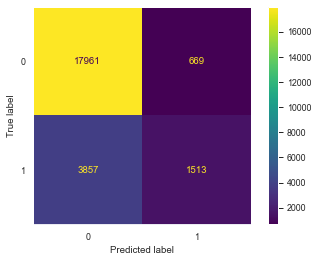

In [11]:

# still to be changed to similar to following models
xgb_reg = fit_Model(xgb_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)


In [12]:
trials = Trials()

ada_objective = build_objective_func(model=AdaBoostRegressor, X_train=X_train, y_train=y_train,
                                      cross_val_method=0)

ada_best_hyperparams = fmin(fn = ada_objective,
                        space = ada_space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

# `ada_space` references the index of the ada_loss_functions, not the name
ada_best_hyperparams['loss'] = ada_loss_functions[ada_best_hyperparams['loss']]

print("The AdaBoostRegressor hyperparameters found are : ","\n")
print(ada_best_hyperparams)

ada_reg = AdaBoostRegressor(**ada_best_hyperparams)


SCORE:                                               
0.7615                                               
100%|██████████| 1/1 [00:03<00:00,  3.36s/trial, best loss: -0.7615]
The AdaBoostRegressor hyperparameters found are :  

{'learning_rate': 0.7455634266916269, 'loss': 'square'}


Performance on fitting data of model AdaBoostRegressor(learning_rate=0.7455634266916269, loss='square') 

Accuracy score: 0.746875
Recall score: 0.5437616387337058
Precision_score: 0.44614209320091675
ROC/AUC score: 0.6745915010630419
F1 score: 0.4901384809064205


Confusion Matrix on the fitting data


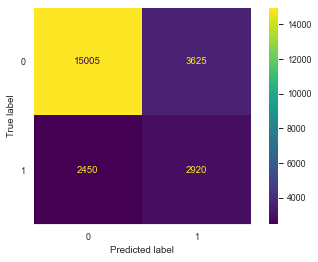

In [13]:

ada_reg = fit_Model(ada_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)



In [14]:

trials = Trials()

gbrt_objective = build_objective_func(model=GradientBoostingRegressor, X_train=X_train, y_train=y_train,
                                      cross_val_method=0, int_keys=gbrt_int_keys)

gbrt_best_hyperparams = fmin(fn = gbrt_objective,
                        space = gbrt_space,
                        algo = tpe.suggest,
                        max_evals = max_evals_gbrt,
                        trials = trials)

for key in gbrt_int_keys:
    gbrt_best_hyperparams[key] = int(gbrt_best_hyperparams[key])

gbrt_best_hyperparams['loss'] = gbrt_loss_functions[gbrt_best_hyperparams['loss']]

print("The GradientBoostingRegressor hyperparameters found are : ","\n")
print(gbrt_best_hyperparams)


SCORE:                                               
0.22216666666666668                                  
100%|██████████| 1/1 [00:12<00:00, 12.24s/trial, best loss: -0.22216666666666668]
The GradientBoostingRegressor hyperparameters found are :  

{'learning_rate': 0.4566378171026144, 'loss': 'quantile', 'max_depth': 5}


Performance on fitting data of model GradientBoostingRegressor(learning_rate=0.4566378171026144, loss='quantile',
                          max_depth=5) 

Accuracy score: 0.2519166666666667
Recall score: 0.9955307262569832
Precision_score: 0.22967863894139887
ROC/AUC score: 0.5165522659733655
F1 score: 0.37324582838790754


Confusion Matrix on the fitting data


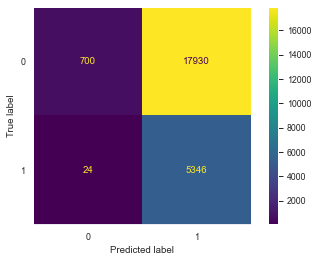

In [15]:
gbrt_reg = GradientBoostingRegressor(**gbrt_best_hyperparams)

gbrt_reg = fit_Model(gbrt_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)



In [16]:
trials = Trials()

log_objective = build_objective_func(model=LogisticRegression, X_train=X_train, y_train=y_train,
                                      cross_val_method=0)


log_best_hyperparams = fmin(fn = log_objective,
                        space = log_space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

log_best_hyperparams['penalty'] = log_penalties[log_best_hyperparams['penalty']]
log_best_hyperparams['solver'] = log_solvers[log_best_hyperparams['solver']]


print("The best hyperparameters are : ","\n")
print(log_best_hyperparams)


SCORE:                                               
0.8091666666666667                                   
100%|██████████| 1/1 [00:00<00:00,  1.05trial/s, best loss: -0.8091666666666667]
The best hyperparameters are :  

{'C': 0.6738819541369224, 'penalty': 'l1', 'solver': 'saga'}


/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Performance on fitting data of model LogisticRegression(C=0.6738819541369224, penalty='l1', solver='saga') 

Accuracy score: 0.8084583333333333
Recall score: 0.23854748603351955
Precision_score: 0.7160424818334264
ROC/AUC score: 0.6056398192379084
F1 score: 0.35787121106299763


Confusion Matrix on the fitting data


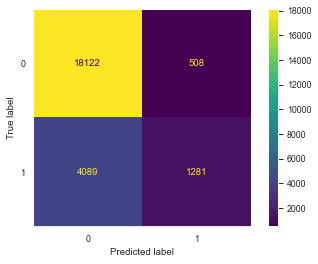

In [17]:

log_reg = LogisticRegression(**log_best_hyperparams)

log_reg = fit_Model(log_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)

In [18]:
trials = Trials()

svm_objective = build_objective_func(model=SVC, X_train=X_train, y_train=y_train,
                                      cross_val_method=0)

svm_best_hyperparams = fmin(fn = svm_objective,
                        space = svm_space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

svm_best_hyperparams['kernel'] = svm_kernels[svm_best_hyperparams['kernel']]
if svm_best_hyperparams['kernel'] != 'poly':
    svm_best_hyperparams.pop('degree')
else:
    svm_best_hyperparams['degree'] = svm_kernel_degrees[svm_best_hyperparams['degree']]


print("The best hyperparameters are : ","\n")
print(svm_best_hyperparams)

SCORE:                                               
0.7803333333333333                                   
100%|██████████| 1/1 [00:13<00:00, 13.93s/trial, best loss: -0.7803333333333333]
The best hyperparameters are :  

{'C': 0.012394096897410722, 'degree': 4, 'kernel': 'poly'}


Performance on fitting data of model SVC(C=0.012394096897410722, degree=4, kernel='poly') 

Accuracy score: 0.7837083333333333
Recall score: 0.043389199255121046
Precision_score: 0.8118466898954704
ROC/AUC score: 0.5202453242652416
F1 score: 0.0823758175711508


Confusion Matrix on the fitting data


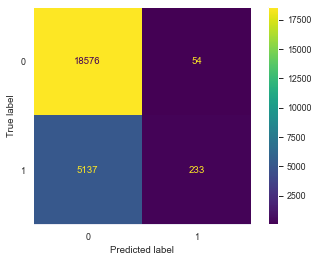

In [19]:
svm_reg = SVC(**svm_best_hyperparams)

svm_reg = fit_Model(svm_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)


The search selects the best considered (not the best in the space) generalizable hyperparameters (i.e. the ones that perform best, after fitting on the training set and prediction on the validation set).
In this limited analysis, these hyperparameters are considered the best generalizable.
Alternatively, we can say that we select these parameters to be tested.
We may find that some ML models allow for a large fluctuation in performance on the validation set, which may indicate that we have 'overfitted' the validation set. This will show on the test set.
We can decide to further train on the validation set, however, it is interesting to see how the performance of the model changes whether we use the validation set or not.

The models are:
`xgb_reg`, `ada_reg`, `gbrt_reg`, `log_reg`, and `svm_reg`

Now we can test these models on the test set. Followed by checking each prediction's 'strenght' by using the Smooth Sorting Method as proposed in the original paper by Yeh and Lien.


### Testing these models


In [20]:
from EvalModel_helper import EvalMetrics

Performance on test data of model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6489510770281239,
             gamma=6.085353999600479, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.24612722594041167,
             max_delta_step=0, max_depth=16, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=51,
             reg_lambda=0.8180080766552988, scale_pos_weight=1, silent=False,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None) 

Accuracy score: 0.827
Recall score: 0.27330173775671407
Precision_score: 0.7456896551724138
ROC/AUC score: 0.6241878355027761
F1 score: 0.4


Confusion Matrix with the true and predicted data
Performance on test data of model AdaBoostRegressor(learning_rate=0.7455634266916269, loss='square

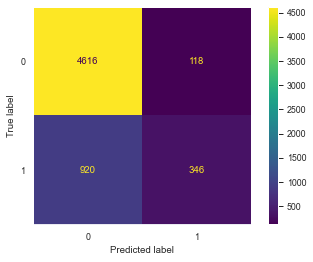

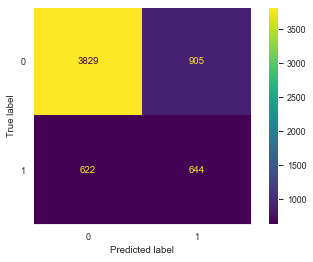

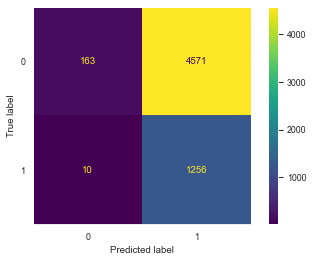

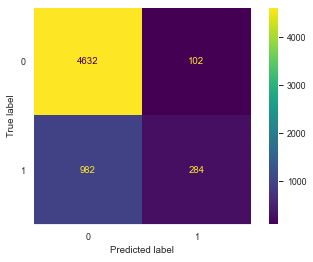

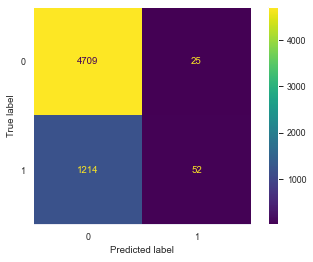

In [21]:
models = [xgb_reg, ada_reg, gbrt_reg, log_reg, svm_reg]
for model in models:
    y_predicted = model.predict(X_test)>0.5
    print(f'Performance on test data of model {model} \n')
    EvalMetrics(y_test, y_predicted, confusion_matrix = True)



We find that these


## Performance at given percentages
### robustness

As opposed to simply classifiying clients as expected to default vs not-expected to default, quantifying is more meaningful. I.e. defining a probability of default has more potential.

To estimate the real probability, the Smooth Sorting Method can be used, which estimates the real probability by looking at neighboring points and taking the mean of these values.

__Smooth Sorting Method__ from the original paper (Yeh, I. C., & Lien, C. H. (2009)): 

$$\text{P}_i = \frac{\sum_{j=-n}^{n}\text{Y}_{i-j}}{2n+1}$$

where $\text{P}_i$ is the estimated real probability of default, $\text{Y}_{i}$ is the binary variable of default (1) or non-default (0), $n$ is the number of data for smoothing.<br>
The Smooth Sorting Method is used on sorted data, from the lowest probability of default occuring to the highest probability of default occuring. 

This is interesting to look at because loaners adopt different risk strategies.    
( (?) for this we consider at 20% and 80% (?) )

we have the lists : `y_predicted` and `y_test`

In [22]:
y_predicted

array([False, False, False, ..., False, False, False])

In [23]:
sorted_index = np.argsort(y_predicted)

y_test = y_test[sorted_index]

KeyError: "None of [Int64Index([   0, 3986, 3985, 3984, 3983, 3982, 3981, 3980, 3979, 3978,\n            ...\n            2086, 5151, 3034, 5268, 5150, 5504, 4743, 5115, 4532, 3915],\n           dtype='int64', name='ID', length=6000)] are in the [index]"

In [ ]:
y_test

In [ ]:
y_avg = []
n = 50
for counter in range(n,len(y_test_sorted)-n):
    intermediate_val = np.mean(y_test_sorted[counter-n:counter+n])
    y_avg.append(intermediate_val)
    
y_predicted_sorted = sorted(y_predicted[n:len(y_predicted)-n])

In [ ]:
plt.plot(y_avg)
plt.show()

In [ ]:
plt.plot(sorted(y_predicted[n:len(y_predicted)-n]),y_avg)
plt.grid(True)
plt.ylim([0,1])
plt.show()

In [ ]:
np.shape(y_predicted[n:len(y_predicted)-n])

In [ ]:
sorted(y_predicted)

In [ ]:
n

In [ ]:
y_predicted_selected = y_predicted[n:len(y_predicted)-n]

In [ ]:

print(r2_score(y_avg,y_predicted_selected))

In [ ]:
len(y_predicted)-n

